## Sensitivity Analysis Experiment
Try out different values of $\lambda$ and $\alpha$ in the cost function on the 10 images in the dataset. See which seems to perform the best on average. 
1. 10 images * 10 $\alpha$s * 10 $\lambda$s = 1000 optimizations. The algorithm doesn't seem very sensitive to starting point, so we ignore this. 
2. 9 columns, image number, $\lambda, \alpha$, then 5 for the confusion matrices, one for f score 

In [7]:
include("objective3.jl")
include("numerical_statistics.jl")
using Images, FileIO, Statistics, LinearAlgebra

In [2]:
nλ = 10#20
nα = 10#20
n_images = 10#10
λ_values = LinRange(.1, 2, nλ)
α_values = LinRange(.005, .05, nα)
summary_h = zeros(nλ*nα*n_images, 1+1+1+1 + 5);
summary_v = zeros(nλ*nα*n_images, 1+1+1+1 + 5);
counter = 1;

In [3]:
for i in 1:n_images
    im_path = "./images2/im"*string(i)*".png"
    hmask_path = "./images2/im"*string(i)*"_hmask.png"
    vmask_path = "./images2/im"*string(i)*"_vmask.png"
    
    # load images
    img = load(im_path);
    imgg = Gray.(img);
    im = convert(Array{Float64}, imgg);

    img_hmask = load(hmask_path);
    imgg_hmask = Gray.(img_hmask);
    im_hmask = convert(Array{Float64}, imgg_hmask);

    img_vmask = load(vmask_path);
    imgg_vmask = Gray.(img_vmask);
    im_vmask = convert(Array{Float64}, imgg_vmask);
    
    for λw in λ_values
        for αw in α_values
            # Set start point of optimization
            imheight, imwidth = size(im) 
            f = .5 .+ randn(imheight, imwidth)/10;
            h = .5 .+ randn(imheight-1, imwidth)/10;
            v = .5 .+ randn(imheight, imwidth-1)/10;

            # ### Interior Point
            niters = 7
            ρs = [1.5625*.2^k for k in 2:niters]
            αws = repeat([αw], niters-1) # .005 seems to work with p, .002 seems to work well with q. .05 maximum
            λs = repeat([λw], niters - 1)
            f,h,v = interior_point(gg, ∇gg, q, ∇q, f, h, v, λs, ρs, αws, im)

            confusion = get_confusion(h,v, im_hmask, im_vmask)
            f_for_both = get_f_score(confusion)
            summary_h[counter, :] .= append!([i, λw, αw], confusion[1, :], [f_for_both])
            summary_v[counter, :] .= append!([i, λw, αw], confusion[2, :], [f_for_both])
            if counter % 10 == 1
                print("\n",counter, " done\n")
                print(summary_h[counter, :], "\n")
            end
            counter += 1
        end
    end
end


1 done
[1.0, 0.1, 0.005, 840.0, 0.0, 0.0, 30.0, 870.0, 0.0]

11 done
[1.0, 0.3111111111111111, 0.005, 840.0, 18.0, 0.0, 12.0, 870.0, 0.8225806451612903]

21 done
[1.0, 0.5222222222222221, 0.005, 840.0, 21.0, 0.0, 9.0, 870.0, 0.8854961832061068]

31 done
[1.0, 0.7333333333333333, 0.005, 840.0, 24.0, 0.0, 6.0, 870.0, 0.9420289855072463]

41 done
[1.0, 0.9444444444444444, 0.005, 840.0, 27.0, 0.0, 3.0, 870.0, 0.971830985915493]

51 done
[1.0, 1.1555555555555557, 0.005, 840.0, 30.0, 0.0, 0.0, 870.0, 0.993103448275862]

61 done
[1.0, 1.3666666666666667, 0.005, 840.0, 28.0, 0.0, 2.0, 870.0, 0.9790209790209791]

71 done
[1.0, 1.5777777777777777, 0.005, 840.0, 27.0, 0.0, 3.0, 870.0, 0.9261744966442953]

81 done
[1.0, 1.7888888888888888, 0.005, 838.0, 27.0, 2.0, 3.0, 870.0, 0.8414634146341463]

91 done
[1.0, 2.0, 0.005, 832.0, 24.0, 8.0, 6.0, 870.0, 0.6947368421052632]

101 done
[2.0, 0.1, 0.005, 822.0, 0.0, 0.0, 48.0, 870.0, 0.0]

111 done
[2.0, 0.3111111111111111, 0.005, 822.0, 14.0, 0.0, 34.


961 done
[10.0, 1.3666666666666667, 0.005, 805.0, 64.0, 1.0, 0.0, 870.0, 0.9953917050691244]

971 done
[10.0, 1.5777777777777777, 0.005, 799.0, 64.0, 7.0, 0.0, 870.0, 0.9642857142857143]

981 done
[10.0, 1.7888888888888888, 0.005, 787.0, 64.0, 19.0, 0.0, 870.0, 0.9113924050632911]

991 done
[10.0, 2.0, 0.005, 770.0, 64.0, 36.0, 0.0, 870.0, 0.8470588235294119]


In [7]:
using DataFrames, CSV
names = ["image", "lambda", "alpha", "true0est0", "true1est1", "true0est1", "true1est0", "total", "F"]
dfH = DataFrame(summary_h, names)
dfV = DataFrame(summary_v, names)
CSV.write("sensitivityH.csv", dfH)
CSV.write("sensitivityV.csv", dfV)

"sensitivityV.csv"

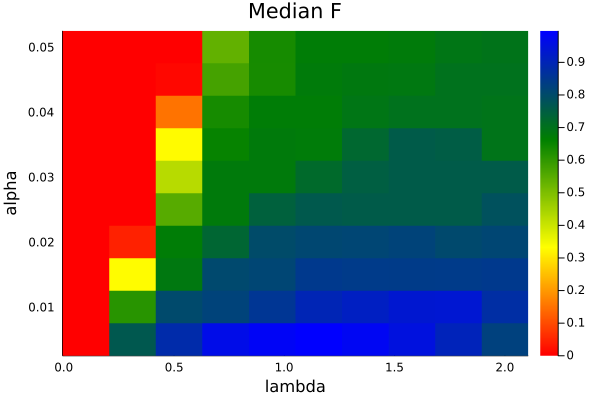

In [68]:
using Plots
median_f = zeros(nλ ,nα)
uniqueλ = unique(summary_h[:, 2])
uniqueα = unique(summary_h[:, 3])
for (i, α) in enumerate(uniqueα)
    for (j, λ) in enumerate(uniqueλ)
        equalsλ = collect(summary_h[:, 2] .== λ)
        equalsα = collect(summary_h[:, 3] .== α)
        #print(sum(equalsλ), " ",sum(equalsα))
        median_f[i,j] = median(summary_h[equalsλ .& equalsα, 9])
    end
end

gr()
heatmap(uniqueλ, uniqueα, 
    median_f,
    c = cgrad([:red, :yellow, :green, :blue]), 
    xlabel = "lambda", 
    ylabel = "alpha", 
    title = "Median F")

#png("sensitivity.png")

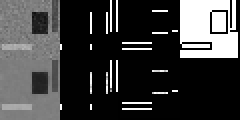

In [8]:
i = 5
im_path = "./images2/im"*string(i)*".png"
hmask_path = "./images2/im"*string(i)*"_hmask.png"
vmask_path = "./images2/im"*string(i)*"_vmask.png"

# load images
img = load(im_path);
imgg = Gray.(img);
im = convert(Array{Float64}, imgg);

img_hmask = load(hmask_path);
imgg_hmask = Gray.(img_hmask);
im_hmask = convert(Array{Float64}, imgg_hmask);

img_vmask = load(vmask_path);
imgg_vmask = Gray.(img_vmask);
im_vmask = convert(Array{Float64}, imgg_vmask);

imheight, imwidth = size(im) 
f = .5 .+ randn(imheight, imwidth)/10;
h = .5 .+ randn(imheight-1, imwidth)/10;
v = .5 .+ randn(imheight, imwidth-1)/10;

niters = 7
ρs = [1.5625*.2^k for k in 2:niters]
αws = repeat([.005], niters-1) # .005 seems to work with p, .002 seems to work well with q. .05 maximum
λs = repeat([1.1], niters - 1)
f,h,v = interior_point(gg, ∇gg, q, ∇q, f, h, v, λs, ρs, αws, im)

edge_image = 1 .- max.(v[1:29, 1:29],h[1:29, 1:29])
edge_image_binary = edge_image .> .5

mosaic(colorview(Gray, im),
colorview(Gray, f),
colorview(Gray, im_vmask),
colorview(Gray, v),
colorview(Gray, im_hmask),
colorview(Gray, h),
colorview(Gray, edge_image_binary), nrow = 2)


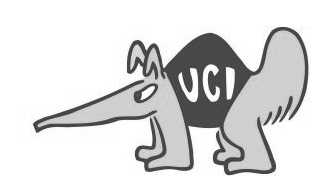

In [8]:
im_path = "anteater.png"
img = load(im_path);
imgg = Gray.(img);
im = convert(Array{Float64}, imgg);
colorview(Gray, im)

In [9]:
imheight, imwidth = size(im) 
f = .5 .+ randn(imheight, imwidth)/10;
h = .5 .+ randn(imheight-1, imwidth)/10;
v = .5 .+ randn(imheight, imwidth-1)/10;

niters = 7
ρs = [1.5625*.2^k for k in 4:niters]
αws = repeat([.005], 4) # .005 seems to work with p, .002 seems to work well with q. .05 maximum
λs = repeat([1.1], 4)
f,h,v = interior_point(gg, ∇gg, q, ∇q, f, h, v, λs, ρs, αws, im)



ρ = 0.0025000000000000005 done
norm(∇f) = 0.40787989032550803
norm(∇h) = 10.856151244483913
norm(∇v) = 12.0004751819705


ρ = 0.0005000000000000001 done
norm(∇f) = 1.5774419523482992
norm(∇h) = 10.878176053024468
norm(∇v) = 12.106409728154018


ρ = 0.00010000000000000003 done
norm(∇f) = 1.4571592773725202
norm(∇h) = 10.959521893322824
norm(∇v) = 12.136134699452915


ρ = 2.000000000000001e-5 done
norm(∇f) = 0.5731360059453913
norm(∇h) = 11.100221036713501
norm(∇v) = 12.318503975928158


([0.9999999999999994 0.9999999999999994 … 0.9999999999999994 0.9999999999999994; 0.9999999999999994 0.9999999999999994 … 0.9999999999999994 0.9999999999999994; … ; 0.9999999999999994 0.9999999999999994 … 0.9999999999999994 0.9999999999999994; 0.9999999999999994 0.9999999999999994 … 0.9999999999999994 0.9999999999999994], [0.27114625089552447 0.28807688601243214 … 0.34021258337811405 0.2765041292382521; 0.3241595098324242 0.3238494327695358 … 0.3129969458167127 0.27198613006633127; … ; 0.36830720363810493 0.3525077690374413 … 0.37182689612401054 0.32049291696124554; 0.34844644745514947 0.27432376749601983 … 0.24810288504999936 0.2533848906833501], [0.32025819380229736 0.35059376300649625 … 0.27403314016514935 0.3330314150376085; 0.254322535240638 0.2896013305297947 … 0.276307391584074 0.28816770455975765; … ; 0.32576058865966595 0.3669404275258266 … 0.2654000109316368 0.25853476613520504; 0.25940152091758456 0.33869466100269924 … 0.2965252585179447 0.3157502281253001])

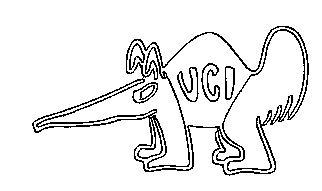

In [16]:
edge_image_ant = 1 .- max.(v[1:imheight-1, 1:imwidth-1],h[1:imheight-1, 1:imwidth-1])
edge_image_ant_binary = edge_image_ant .> .5
colorview(Gray, edge_image_ant_binary)

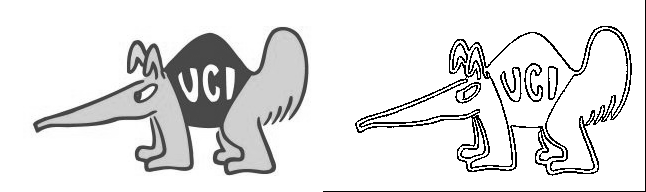

In [17]:
mosaic(colorview(Gray, im), colorview(Gray, edge_image_ant_binary), nrow= 1)



ρ = 0.0025000000000000005 done
norm(∇f) = 0.37494186029543386
norm(∇h) = 2.021096596281438
norm(∇v) = 3.016260824257124


ρ = 0.0005000000000000001 done
norm(∇f) = 0.48080371058458155
norm(∇h) = 2.0870074040338933
norm(∇v) = 3.0581981502879474


ρ = 0.00010000000000000003 done
norm(∇f) = 0.5659888907644449
norm(∇h) = 2.052501638250828
norm(∇v) = 2.9831390285265753


ρ = 2.000000000000001e-5 done
norm(∇f) = 0.5775517344188844
norm(∇h) = 2.173229764750247
norm(∇v) = 3.0413325655414276


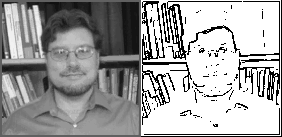

In [18]:
im_path = "mjolsness.png"
img = load(im_path);
imgg = Gray.(img);
im = convert(Array{Float64}, imgg);
colorview(Gray, im)

imheight, imwidth = size(im) 
f = .5 .+ randn(imheight, imwidth)/10;
h = .5 .+ randn(imheight-1, imwidth)/10;
v = .5 .+ randn(imheight, imwidth-1)/10;

niters = 7
ρs = [1.5625*.2^k for k in 4:niters]
αws = repeat([.005], 4) # .005 seems to work with p, .002 seems to work well with q. .05 maximum
λs = repeat([1.1], 4)
f,h,v = interior_point(gg, ∇gg, q, ∇q, f, h, v, λs, ρs, αws, im)

edge_image_ant = 1 .- max.(v[1:imheight-1, 1:imwidth-1],h[1:imheight-1, 1:imwidth-1])
edge_image_ant_binary = edge_image_ant .> .5
#colorview(Gray, edge_image_ant_binary)
mosaic(colorview(Gray, im), colorview(Gray, edge_image_ant_binary), nrow= 1)